In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,precision_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter

from scipy.stats import norm, multivariate_normal

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(0)

In [2]:
def data_preparation(data):
    features = data.iloc[:,0:-1]
    label = data.iloc[:,-1]
    x_train,x_test,y_train,y_test = train_test_split(features,label,test_size=0.2,random_state=0)

    #Standarad scaler is not applied since all the features are outcomes of PCA and are already normalized.
    #sc = StandardScaler()
    #x_train = sc.fit_transform(x_train)
    #x_test = sc.transform(x_test)
    
    print("Length of training data",len(x_train))
    print("Length of test data",len(x_test))
    return x_train,x_test,y_train,y_test
    

In [3]:
def build_model_train_test(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)

    y_pred = model.predict(x_train)
    
    print("\n----------Accuracy Scores on Train data------------------------------------")
    #print("Clasification Report")
    #print(classification_report(y_train,y_pred))

    print("F1 Score: ", f1_score(y_train,y_pred))
    print("Precision Score: ", precision_score(y_train,y_pred))
    print("Recall Score: ", recall_score(y_train,y_pred))

    print("\n----------Accuracy Scores on Cross validation data------------------------------------")
    y_pred_cv = cross_val_predict(model,x_train,y_train,cv=5)
    print("F1 Score: ", f1_score(y_train,y_pred_cv))
    print("Precision Score: ", precision_score(y_train,y_pred_cv))
    print("Recall Score: ", recall_score(y_train,y_pred_cv))


    print("\n----------Accuracy Scores on Test data------------------------------------")
    y_pred_test = model.predict(x_test)
    
    #print("Clasification Report")
    #print(classification_report(y_test,y_pred_test))

    print("F1 Score: ", f1_score(y_test,y_pred_test))
    print("Precision Score: ", precision_score(y_test,y_pred_test))
    print("Recall Score: ", recall_score(y_test,y_pred_test))

    #Confusion Matrix
    plt.figure(figsize=(18,6))
    gs = gridspec.GridSpec(1,2)

    ax1 = plt.subplot(gs[0])
    cnf_matrix = confusion_matrix(y_train,y_pred)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Train Data")

#     ax2 = plt.subplot(gs[1])
#     cnf_matrix = confusion_matrix(y_train,y_pred_cv)
#     sns.heatmap(cnf_matrix,cmap='YlGnBu',annot=True,fmt='d')
#     plt.title("Confusion Matrix - CV Data")

    ax3 = plt.subplot(gs[1])
    cnf_matrix = confusion_matrix(y_test,y_pred_test)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Test Data")


In [4]:
def build_model_train(model,x_train,y_train):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    
    #print("Clasification Report")
    #print(classification_report(y_train,y_pred))

    print("\n----------Accuracy Scores on Train data------------------------------------")
    print("F1 Score: ", f1_score(y_train,y_pred))
    print("Precision Score: ", precision_score(y_train,y_pred))
    print("Recall Score: ", recall_score(y_train,y_pred))

    print("\n----------Accuracy Scores on Cross validation data------------------------------------")
    y_pred_cv = cross_val_predict(model,x_train,y_train,cv=5)
    print("F1 Score: ", f1_score(y_train,y_pred_cv))
    print("Precision Score: ", precision_score(y_train,y_pred_cv))
    print("Recall Score: ", recall_score(y_train,y_pred_cv))
    
    cnf_matrix = confusion_matrix(y_train,y_pred)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum 
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Train data")


In [5]:
def build_model_test(model,x_test,y_test):

    y_pred_test = model.predict(x_test)
    #print("Clasification Report - Test Data")
    #print(classification_report(y_test,y_pred_test))

    print("F1 Score: ", f1_score(y_test,y_pred_test))
    print("Precision Score: ", precision_score(y_test,y_pred_test))
    print("Recall Score: ", recall_score(y_test,y_pred_test))

    cnf_matrix = confusion_matrix(y_test,y_pred_test)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    cnf_matrix_norm =cnf_matrix / row_sum 
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
    plt.title("Normalized Confusion Matrix - Test data")


In [6]:
def SelectThresholdByCV(probs,y):
    best_threshold = 0
    best_f1 = 0
    f = 0
    precision =0
    recall=0
    best_recall = 0
    best_precision = 0
    precisions=[]
    recalls=[]
    
    thresholds = np.arange(0.0,1.0,0.001)
    for threshold in thresholds:
        predictions = (probs > threshold)
        f = f1_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        #print("Threshold {0},Precision {1},Recall {2}".format(threshold,precision,recall))
        
        if f > best_f1:
            best_f1 = f
            best_precision = precision
            best_recall = recall
            best_threshold = threshold

        precisions.append(precision)
        recalls.append(recall)

    #Precision-Recall Trade-off
    plt.plot(thresholds,precisions,label='Precision')
    plt.plot(thresholds,recalls,label='Recall')
    plt.xlabel("Threshold")
    plt.title('Precision Recall Trade Off')
    plt.legend()
    plt.show()

    print ('Best F1 Score %f' %best_f1)
    print ('Best Precision Score %f' %best_precision)
    print ('Best Recall Score %f' %best_recall)
    print ('Best Epsilon Score', best_threshold)


In [7]:
def SelectThresholdByCV_Anomaly(probs,y):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    precision =0
    recall=0
    best_recall = 0
    best_precision = 0
    
    epsilons = sorted(np.unique(probs))
    #print(epsilons)
    
    precisions=[]
    recalls=[]
    for epsilon in epsilons:
        predictions = (probs < epsilon)
        f = f1_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        #print("Theshold {0},Precision {1},Recall {2}".format(epsilon,precision,recall))
          
        if f > best_f1:
            best_f1 = f
            best_precision = precision
            best_recall = recall
            best_epsilon = epsilon
        
        precisions.append(precision)
        recalls.append(recall)

    #Precision-Recall Trade-off
    plt.plot(epsilons,precisions,label='Precision')
    plt.plot(epsilons,recalls,label='Recall')
    plt.xlabel("Epsilon")
    plt.title('Precision Recall Trade Off')
    plt.legend()
    plt.show()

    print ('Best F1 Score %f' %best_f1)
    print ('Best Precision Score %f' %best_precision)
    print ('Best Recall Score %f' %best_recall)
    print ('Best Epsilon Score', best_epsilon)

In [8]:
def Print_Accuracy_Scores(y,y_pred):
    print("F1 Score: ", f1_score(y,y_pred))
    print("Precision Score: ", precision_score(y,y_pred))
    print("Recall Score: ", recall_score(y,y_pred))


In [9]:
#Loading Dataset
cc_dataset = pd.read_csv("/home/shubham/Downloads/creditcard.csv")

In [10]:
cc_dataset.shape

(284807, 31)

In [11]:
cc_dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
cc_dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
#Code for checking if any feature has null values
cc_dataset.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [14]:
#Counts for each class in the dataset. As you can see, we have only 492 (0.17%) fraud cases out of 284807 records. Remaining 284315 (99.8%) of the records belong to genuine cases.
cc_dataset['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

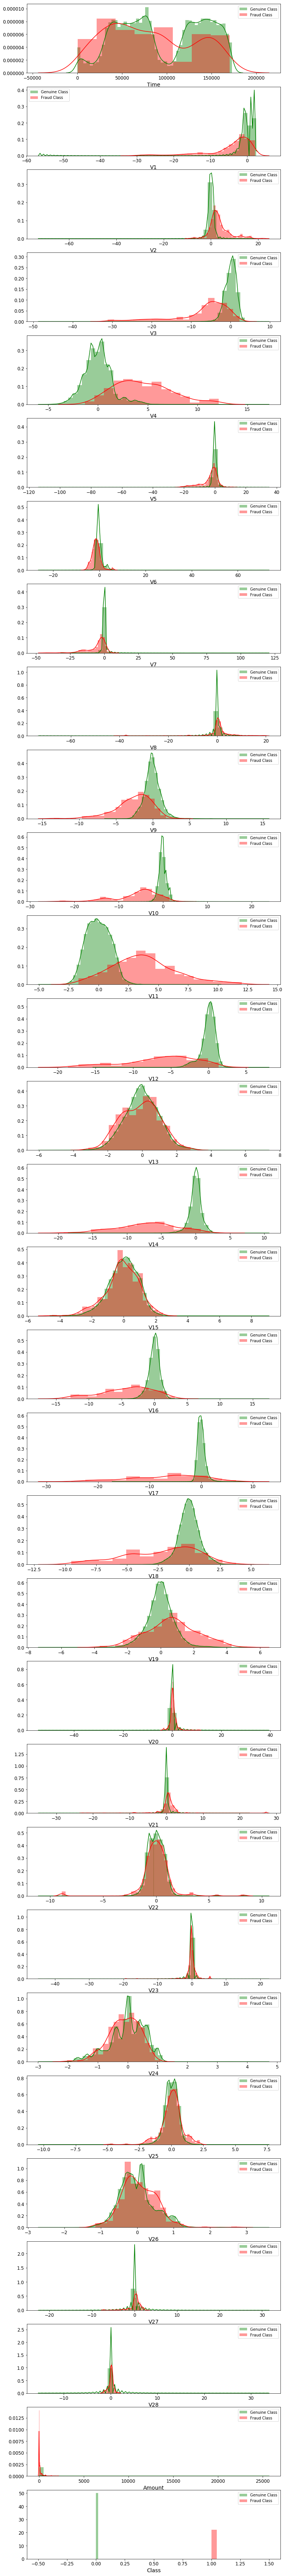

In [15]:
#Data Visualization for checking the distribution for Genuine cases & Fraud cases for each feature
v_features = cc_dataset.columns
plt.figure(figsize=(12,31*4))
gs = gridspec.GridSpec(31,1)

for i, col in enumerate(v_features):
    ax = plt.subplot(gs[i])
    sns.distplot(cc_dataset[col][cc_dataset['Class']==0],color='g',label='Genuine Class')
    sns.distplot(cc_dataset[col][cc_dataset['Class']==1],color='r',label='Fraud Class')
   
    ax.legend()
plt.show()

Feature selection: 
    1) We can see Normal Distribution of anomalous transactions (class = 1) is matching with Normal Distribution of genuine transactions (class = 0) for V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8' features. It is better to delete these features as they may not be useful in finding anomalous records.
    2) Time is also not useful variable since it contains the seconds elapsed between the transaction for that record and the first transaction in the dataset. So the data is in increasing order always.
so,what have we done that we can plot in differ pattren so the plot clar graph will made for the client
However we'll delete these features only after building a dumb model.

In [16]:
#Splitting the input features and target label into different arrays
X = cc_dataset.iloc[:,0:-1]
Y = cc_dataset.iloc[:,-1]
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [17]:
#Train Test split - By default train_test_split does STRATIFIED split based on label (y-value).
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [18]:
#Feature Scaling - Standardizing the scales for all x variables
#PN: We should apply fit_transform() method on train set & only transform() method on test set
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [19]:
#Build a basic SGDClassifier model
sgd_cls = SGDClassifier(class_weight='balanced', random_state=0)
sgd_cls.fit(x_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
#Predict target variable (Y-label)
y_pred = sgd_cls.predict(x_train)

In [21]:
#Classification_report provides main classification metrics(precision, recall & f1-score) for each class
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    227454
           1       0.03      0.93      0.06       391

   micro avg       0.95      0.95      0.95    227845
   macro avg       0.52      0.94      0.52    227845
weighted avg       1.00      0.95      0.97    227845



In [22]:
Print_Accuracy_Scores(y_train,y_pred)

F1 Score:  0.05901532442125856
Precision Score:  0.030479077208049172
Recall Score:  0.9258312020460358


From the basic SGDClassifier model we got a very good score for Recall but Precision is very low. So we need to approach GridSearchCV to tune and find best hyper-parameter values.

Note: We have commented GridSearchCV code as it is taking long time to execute. So we took only couple of hyper-parameters & build the best model


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.8120104438642297
Precision Score:  0.8293333333333334
Recall Score:  0.7953964194373402

----------Accuracy Scores on Cross validation data------------------------------------
F1 Score:  0.8010139416983523
Precision Score:  0.7939698492462312
Recall Score:  0.8081841432225064

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.8177339901477833
Precision Score:  0.8137254901960784
Recall Score:  0.8217821782178217


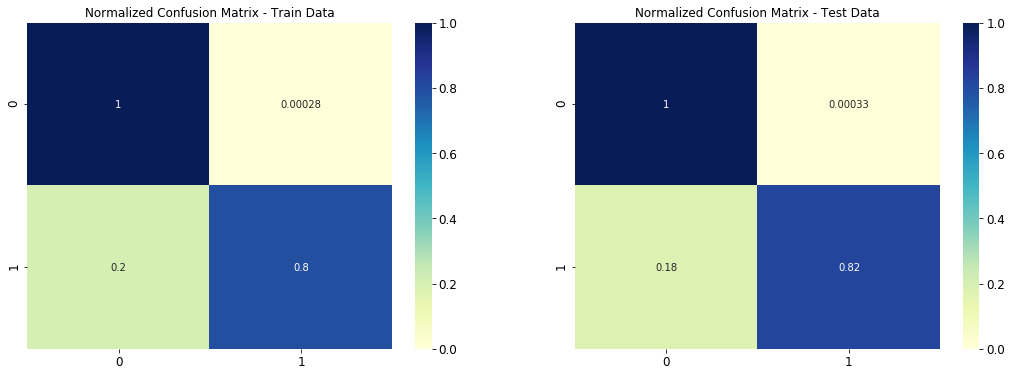

In [23]:
#Build the best model out of GridSearchCV
best_sgd_clf = SGDClassifier(alpha=5, class_weight='balanced',random_state=0)
build_model_train_test(best_sgd_clf,x_train,x_test,y_train,y_test)

By looking at the performance measures on Test data, So we can conclude that SGDClassifier has provided good results on both train and test data sets with F1, Precision and Recall scores around 80%

Note: For fraud detection, recall score is more important than precision score.

I've used class_weight='balanced' parameter for all the models since the data is imbalanced. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as "n_samples / (n_classes * np.bincount(y))". So the model applies more weights to rare classes.

Confusion Matrix - Normalization can be interesting in case of class imbalance to have a more visual interpretation of which class is being misclassified. You can see from the above normalized confusion matrix that 20% of the Fraud records are misclassified in this model. So there is still lot of scope for improvement.

In [24]:
featimp = pd.Series(best_sgd_clf.coef_.ravel(),index=X.columns).sort_values(ascending=False)
print(featimp)



V11       0.049538
V4        0.046046
V2        0.015425
V21       0.013185
V27       0.008045
Amount    0.005440
V28       0.005412
V19       0.004297
V20       0.003498
V25       0.000611
V26       0.000114
V15       0.000028
V22      -0.000997
Time     -0.003113
V5       -0.004090
V24      -0.004184
V13      -0.005872
V23      -0.006081
V8       -0.009319
V18      -0.011246
V1       -0.014094
V6       -0.017773
V9       -0.021456
V7       -0.031597
V16      -0.038148
V3       -0.047460
V17      -0.054354
V10      -0.057447
V12      -0.070584
V14      -0.107986
dtype: float64


We can see that coefficients for SGDClassifier model are almost close to zero for the features: V27,Amount,V28,V19,V20,V25,V26,V15,V22,Time,V5,V24,V13,V8

In [25]:
#Decision scores or Confidence scores - Is a measure of distance of that sample to decision boundary hyperplane
y_pred_decision = best_sgd_clf.decision_function(x_train)


In [26]:
#Precision recall curve - Computes precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train,y_pred_decision)


Text(0.5, 1.0, 'Precision Recall Curve')

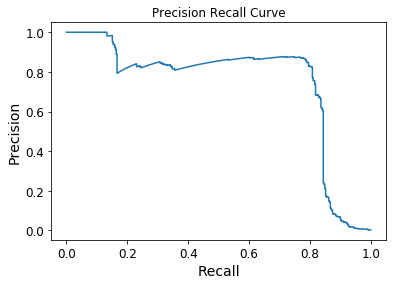

In [27]:
plt.plot(recalls,precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

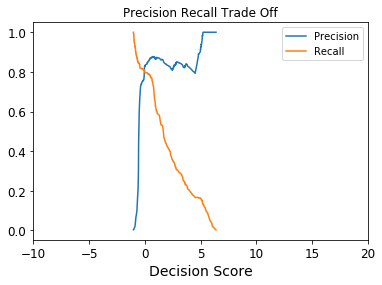

In [28]:
#Precision-Recall Trade-off
plt.plot(thresholds,precisions[:-1],label='Precision')
plt.plot(thresholds,recalls[:-1],label='Recall')

plt.xlabel("Decision Score")
plt.title('Precision Recall Trade Off')
plt.legend()
plt.xlim([-10,20])
plt.show()

Precision Recall Trade Off also suggests that decision score of 0 provides better accuracy scores for Precision and Recall. So we can assume this is the best model from SGDClassifier.

For Demonstration purpose, I created ROC curve as well below. However ROC AUC score is not a good measure for imbalance data sets as discussed above.
You can notice that the above model has given us the AUC score of 0.98, which is very high.

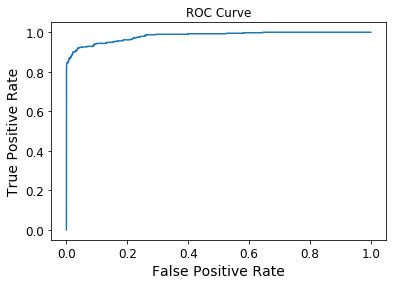

In [29]:
fpr, tpr, thesholds = roc_curve(y_train,y_pred_decision)

plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [30]:
roc_auc_score(y_train,y_pred_decision)

0.9815024119882187

# Step2 - Ensemble Models

Ensemble models may handle imbalanced datasets better due to their nature of building multiple models randomly and aggregate their predictions.

In [31]:
# #Use GridSearchCV to find the best parameters for RandomForest algorithm
# param_grid = {
#     'n_estimators':[50,100,200],
#     'max_depth':[4,6,8,10],
#     'min_samples_split':[5,10,20,50]
# }

# rnd_clf = RandomForestClassifier(criterion='gini',class_weight='balanced', n_jobs=-1, random_state=0)
# grid_search = GridSearchCV(rnd_clf,param_grid,cv=5,scoring='f1_weighted')
# grid_search.fit(x_train,y_train)

In [32]:
# grid_search.best_estimator_


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.9240196078431372
Precision Score:  0.8870588235294118
Recall Score:  0.9641943734015346

----------Accuracy Scores on Cross validation data------------------------------------
F1 Score:  0.8165997322623828
Precision Score:  0.8567415730337079
Recall Score:  0.7800511508951407

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.8426395939086294
Precision Score:  0.8645833333333334
Recall Score:  0.8217821782178217


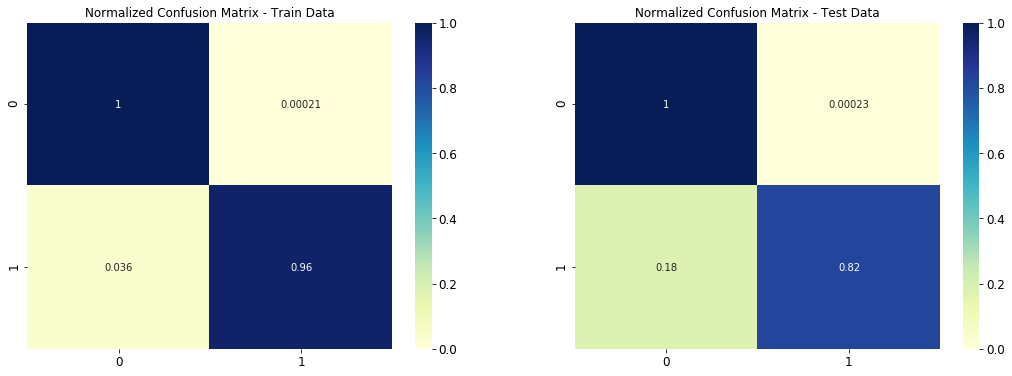

In [33]:
#Best estimator of random forest
rnd_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
build_model_train_test(rnd_clf,x_train,x_test,y_train,y_test)

In [34]:
#Check the Feature importance scores from Random Forest model
featimp = pd.Series(rnd_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
print(featimp)

V14       0.260662
V10       0.135446
V12       0.104045
V4        0.075028
V11       0.070356
V16       0.052525
V2        0.039300
V17       0.037054
V3        0.030586
V18       0.021279
V21       0.015656
V8        0.015445
V19       0.014812
V7        0.014673
V20       0.011620
V5        0.010967
V27       0.010901
Amount    0.010281
V15       0.007762
V1        0.007631
V26       0.007295
V13       0.006983
V28       0.006392
V25       0.005870
V9        0.005737
V23       0.005567
V6        0.004747
Time      0.004264
V22       0.004034
V24       0.003082
dtype: float64


We can see that most of the features we have decided to remove after looking at the distribution earlier are having low importance scores in random forest model & also coefficients close to zero at SGCClassifier. Let us remove these features for further analysis.

In [35]:
cc_dataset.drop(labels = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8','Time'], axis = 1, inplace=True)
cc_dataset.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12',
       'V14', 'V16', 'V17', 'V18', 'V19', 'V21', 'Amount', 'Class'],
      dtype='object')

In [36]:
cc_dataset.describe()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,1.206296e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,1.656562e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.585956e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.345240e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-1.921433e+01,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-3.483038e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-4.255740e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.283949e-01,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,5.060132e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-2.945017e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,4.931498e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.863772e-01,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,1.052677e+01,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,2.720284e+01,25691.160000,1.000000


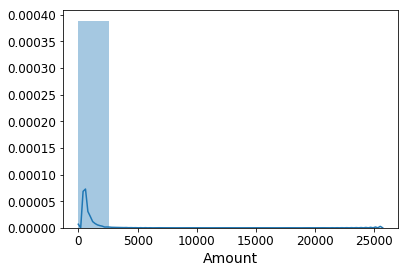

In [37]:
sns.distplot(cc_dataset['Amount'],bins=10)

The feature 'Amount' has higher standard deviation of 250, which indicate the spread is very high & also we might have outliers in the data. So let us go for feature scaling for Amount variable using StandardScaler().

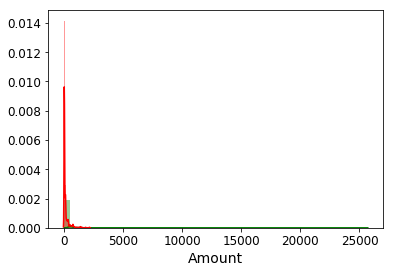

In [38]:
sns.distplot(cc_dataset['Amount'][cc_dataset['Class']==0],color='g',label='Genuine Class')
sns.distplot(cc_dataset['Amount'][cc_dataset['Class']==1],color='r',label='Fraud Class')

In [39]:
#Data Preparation
x_train,x_test,y_train,y_test = data_preparation(cc_dataset)

Length of training data 227845
Length of test data 56962


In [ ]:
#Let us check the performance of RandomForest after removing few features
build_model_train_test(rnd_clf,x_train,x_test,y_train,y_test)


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.9191797346200241
Precision Score:  0.8698630136986302
Recall Score:  0.9744245524296675

----------Accuracy Scores on Cross validation data------------------------------------


You can notice that RandomForest has given pretty decent performance on this dataset though it is overfitting little bit. Also notice that same accuracy is maintained even after removing the features ('V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8','Time').

I developed KNN algorithm here, mainly to use it in Voting Classifier. But KNN is giving us pretty good performance as well. 

In [ ]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
build_model_train_test(knn_clf,x_train,x_test,y_train,y_test)

Let us also try AdaBoostClassifier before using voting classifier. 
Looking at below scores, we can say that AdaBoost is overfitting on the training data. Overall a good performance on the cross validation and test dataset nevertheless.

In [ ]:
ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3,class_weight='balanced'), n_estimators=100,
        algorithm="SAMME.R", learning_rate=0.5, random_state=0
    )
build_model_train_test(ada_clf,x_train,x_test,y_train,y_test)

RandomForest, AdaBoost & KNN are all providing good accuracy measures. So let us include all of them in a soft voting classifier and see if we can improve the performance even further.

In [ ]:
soft_voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('ada', ada_clf), ('knn',knn_clf)], 
    voting='soft')

build_model_train_test(soft_voting_clf,x_train,x_test,y_train,y_test)

I'm pretty happy with the outcome of Voting Classifier here though it is over fitting on the train data set. But a deviation of 5% is acceptable.
I'd like to improve the recall score further. So let us use predict_proba to get the probabilities and see if we can improve the recall by using a different threshold.

In [ ]:
#Probability scores for each record for prediction
probs_sv_test = soft_voting_clf.predict_proba(x_test)

In [ ]:
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_sv_test[:,1],y_test)

In [ ]:
y_pred_test = (probs_sv_test[:,1] > 0.571)
Print_Accuracy_Scores(y_test,y_pred_test)

However we couldn't improve the recall score much on the test data. Precision is going down drastically if we try to improve recall little bit. So I'd imagine that the model has given us best results with 83 recall score and 95 precision score at 0.57 threshold.

Conclusion: From adhoc approach, we have seen slightly better results for Voting Classifier than RandomForest. So we could go with Voting Classifier with F1-score of 89 and Recall score of 83. 
However we are going to check the performance of both Voting Classifier and RandomForest in our next approach using resampling technique.

# Approach 2 - Resampling Techniques

In this approach we are going to balance the data using resampling techniques. The main objective of resampling is to balance classes by either increasing the frequency of minority class or decreasing the frequency of majority class.

We can use imbalanced-learn library of python to resample the data. But we are going to use manual approach first for the demonstration purpose and see the synthetic approach later on using oversampling.

# Step1 - Under Sampling

Here we randomly choose only a sample of genuine records, which will make sure to balance the instances of majority and minority classes.

In [ ]:
genuine_data = cc_dataset[cc_dataset['Class']==0]
fraud_data = cc_dataset[cc_dataset['Class']==1]

In [ ]:
genuine_indexes = genuine_data.index
fraud_indexes = fraud_data.index
count_genuine = len(genuine_data)
count_fraud = len(fraud_data)

In [ ]:
#Choose a smaple of genuine records which is equal to number of fraud records 
genuine_indexes_undersample = np.random.choice(genuine_indexes,count_fraud,replace=False)
print(len(genuine_indexes_undersample))

In [ ]:
#Merge under-sampled genuine records with fraud records to get the final under-sampled dataset
undersample_indexes = np.concatenate((genuine_indexes_undersample,fraud_indexes),axis=0)
print(len(undersample_indexes))

In [ ]:
undersample_data = cc_dataset.iloc[undersample_indexes,:].values

In [ ]:
#Split X & Y
us_data_x = undersample_data[:,0:-1]
us_data_y = undersample_data[:,-1]

In [ ]:
#Model building on under-sampled train data and then check the accuracy scores on train, test data.
#Note: Class_weight='balanced' parameter is removed for the model on under-sample since the training data is balanced after using under-sampling technique.
rnd_clf = RandomForestClassifier(n_estimators=100,criterion='gini', n_jobs=-1, random_state=0)
#Train the model on under-sampled data and check the performance on actual test data
build_model_train_test(rnd_clf,us_data_x,x_test,us_data_y,y_test)

You can notice that precision has gone down miserably on the original imbalanced test data when we trained the model on under-sampled data. This is due to potential loss of information/examples during the training. So the under-sampled data will not be an accurate representation of the population. Thereby, resulting in inaccurate results with the actual test data set.

# Step2 - Over Sampling

Over-Sampling increases the number of instances in the minority class by randomly replicating them in order to present a higher representation of the minority class in the sample.

In [ ]:
y_train = y_train.reshape(-1,1) #Reshaping Y to 2 dimensional array

data_train = np.hstack((x_train,y_train)) #Stack Y label with input X array
print("Length of Training Data",len(data_train))
genuine_data = data_train[data_train[:,-1]==0]
print("Length of Genuine Data",len(genuine_data))
fraud_data = data_train[data_train[:,-1]==1]
print("Length of Fraud Data",len(fraud_data))


In [ ]:
#Code for adding the fraud records 200 times to the training set. So overall we are able to get 75:25 ratio of genuine to fraud class in the over-sampled data.
os_data = genuine_data.copy()
for i in range(200):
    os_data = np.vstack((os_data,fraud_data))

print("Length of Training Data",len(os_data))
print("Length of Genuine Data",len(os_data[os_data[:,-1]==0]))
print("Length of Fraud Data",len(os_data[os_data[:,-1]==1]))


In [ ]:
#Split X & Y
os_data_x = os_data[:,0:-1]
os_data_y = os_data[:,-1]

In [ ]:
#Model building on over-sampled train data and then check the accuracy scores on train and test data.
rnd_clf = RandomForestClassifier(n_estimators=100,criterion='gini',class_weight='balanced',n_jobs=-1, random_state=0)
#Train the model on over-sampled data and check the performance on actual test data
build_model_train_test(rnd_clf,os_data_x,x_test,os_data_y,y_test)

In [ ]:
#Probability score for each record for prediction
probs_rf_test = rnd_clf.predict_proba(x_test)

In [ ]:
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_rf_test[:,1],y_test)

In [ ]:
y_pred_test = (probs_rf_test[:,1] > 0.32)
Print_Accuracy_Scores(y_test,y_pred_test)


Conclusion: Over-sampling fraud records to 25% of overall training samples is providing best results when combined with class_weight='balanced' parameter for RandomForest.

In [ ]:
#Let us check the cross validation scores on the original train data set
cv_score = cross_val_score(rnd_clf,x_train,y_train,cv=5,scoring='f1')
print("Average F1 score CV",cv_score.mean())

In [ ]:
cv_score = cross_val_score(rnd_clf,x_train,y_train,cv=5,scoring='recall')
print("Average Recall score CV",cv_score.mean())

From the above cross validation scores, it looks like the RandomForest model is overfitting little bit. We will use the scores on cross validation for choosing the best model. 

Let us check the performance of Soft Voting Classifier as well on this over-sampled data.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100,criterion='gini',class_weight='balanced', n_jobs=-1, random_state=0)

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3,class_weight='balanced'), n_estimators=100,
        algorithm="SAMME.R", learning_rate=0.5, random_state=0
    )
knn_clf = KNeighborsClassifier(n_neighbors=3)

soft_voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('ada', ada_clf), ('knn',knn_clf)], 
    voting='soft')

#Train the model on oversampled data and check the performance on actual test data
build_model_train_test(soft_voting_clf,os_data_x,x_test,os_data_y,y_test)

In [ ]:
#Probability scores for each record for prediction
probs_sv_test = soft_voting_clf.predict_proba(x_test)

In [ ]:
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_sv_test[:,1],y_test)

In [ ]:
y_pred_test = (probs_sv_test[:,1] > 0.546)
Print_Accuracy_Scores(y_test,y_pred_test)

Using Soft Voting Classifier, recall is improving little bit when we reduce the threshold. However precision is going down pretty quickly to improve little bit of recall. So I choose the threshold of 0.546, which is giving us reasonable recall (in line with the original model) and the best precision score.

Note: Oversampled data has given slightly better results than the original data (F1 score of 89 vs 88) with slight increase in recall and precision.

So we can conclude that over-sampling fraud records to 25% of overall training samples is providing best results when combined with class_weight='balanced' parameter using soft voting classifier.

In [ ]:
#Let us check the cross validation scores on the original train data set
cv_score = cross_val_score(soft_voting_clf,x_train,y_train,cv=5,scoring='f1')
print("Average F1 score CV",cv_score.mean())

In [ ]:
cv_score = cross_val_score(soft_voting_clf,x_train,y_train,cv=5,scoring='recall')
print("Average Recall score CV",cv_score.mean())

Conclusion: Both RandomForest and Voting Classifier have given us similar results on the over-sampled data using manual process(projecting fraud cases to 25% of the total  training examples).  

However Voting Classifier has given better results on K-fold cross validation on the original train dataset. So I'd go with Voting Classifier as the final model selection using manual process of over-sampling.

# Step3 - Over Sampling using SMOTE

imbalanced-learn is a python package offering a number of re-sampling techniques commonly used in datasets showing strong between-class imbalance. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

imbalanced-learn is currently available on the PyPi's repository and you can install it via pip: pip install -U imbalanced-learn

Here we are going to explore Synthetic Minority Oversampling Technique (SMOTE).

In [ ]:
os = SMOTE(random_state=0)

In [ ]:
#Generate the oversample data
os_res_x,os_res_y=os.fit_sample(x_train,y_train)
#Counts of each class in oversampled data
print(sorted(Counter(os_res_y).items()))

We can see that fraud records are imputed and brought close to genuine records in this oversampled data using SMOTE. Hence both classes are equally distributed now.

In [ ]:
#RandomForest for training over-sampled data set. 
#Note: we have removed class_weight='balanced' since the data is balanced using SMOTE.
rnd_clf = RandomForestClassifier(n_estimators=100,criterion='gini',n_jobs=-1, random_state=0)
#Train the model on oversampled data and check the performance on actual test data
build_model_train_test(rnd_clf,os_res_x,x_test,os_res_y,y_test)

In [ ]:
#Probability scores for each record for prediction
probs_rf_test = rnd_clf.predict_proba(x_test)

In [ ]:
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_rf_test[:,1],y_test)

In [ ]:
y_pred_test = (probs_rf_test[:,1] > 0.63)
Print_Accuracy_Scores(y_test,y_pred_test)

We could improve the precision score by changing the threshold to 0.63

In [ ]:
#Let us check cross validation scores on the orginal train data
cv_score = cross_val_score(rnd_clf,x_train,y_train,cv=5,scoring='f1')
print("Average F1 score CV",cv_score.mean())

In [ ]:
cv_score = cross_val_score(rnd_clf,x_train,y_train,cv=5,scoring='recall')
print("Average Recall score CV",cv_score.mean())

RandomForest has almost the same results on test data for both manual and synthetic over-sampling approaches: F1 score of 88 using manual approach vs 86 using synthetic approach and both the approaches providing 85 recall score. 

However on the cross validation, Synthetic approach (F1-score of 85 and Recall score of 78) has better scores compared to manual approach (F1-score of 82 and Recall score of 73). 

So SMOTE has an edge over manual over-sampling approach for RandomForest.

Let us check the performance of Soft Voting Classifier on this over-sampled data.

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100,criterion='gini', n_jobs=-1, random_state=0)

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=3), n_estimators=100,
        algorithm="SAMME.R", learning_rate=0.5, random_state=0
    )
knn_clf = KNeighborsClassifier(n_neighbors=3)

soft_voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('ada', ada_clf), ('knn',knn_clf)],
    voting='soft')

#Train the model on oversampled data and check the performance on actual test data
build_model_train_test(soft_voting_clf,os_res_x,x_test,os_res_y,y_test)

Precision score has gone down on test data using Synthetic over-sampled data approach. This could be because of the model parameters. Let us try to change the threshold and see if we can improve precision while still maintaining the recall score around 85.

In [ ]:
#Probability scores for each record for prediction
probs_sv_test = soft_voting_clf.predict_proba(x_test)

In [ ]:
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_sv_test[:,1],y_test)

In [ ]:
y_pred_test = (probs_sv_test[:,1] > 0.718)
Print_Accuracy_Scores(y_test,y_pred_test)

In [ ]:
#Let us check cross validation scores on the original train data
cv_score = cross_val_score(soft_voting_clf,x_train,y_train,cv=5,scoring='f1')
print("Average F1 score CV",cv_score.mean())

In [ ]:
cv_score = cross_val_score(soft_voting_clf,x_train,y_train,cv=5,scoring='recall')
print("Average Recall score CV",cv_score.mean())

Voting Classifier has given almost the same results on test data and cross validation for both manual over-sampling and synthetic over-sampling. PN: Accuracy is almost same using adhoc approach as well for Voting classifier. (F1 score of 89 and recall score of 83). So Voting classifier has performed consistently in all 3 trials we did so far.

Whereas RandomForest is not far behind too and given the same accuracy scores as Voting Classifier using SMOTE. 

So I'd recommend using SMOTE approach and choose either RandomForest or Soft Voting Classifier as the final model.

# Approach 3 - Anomaly Detection using Gaussian (Normal) Distribution

For training and evaluating Gaussian distribution algorithms, we are going to split the train, cross validation and test data sets using blow ratios.
    1) Train:  60% of the Genuine records (y=0), no Fraud records(y=1). So the training set will not have a label as well.
    2) CV:  20% of the Genuine records (y=0), 50% of the Fraud records(y=1)
    3) Test: Remaining 20% of the Genuine records(y=0), Remaining 50% of the Fraud records(y=1)

Procedure for anomaly detection:
    1) Fit the model p(x) on training set.
    2) On cross validation/test data, predict
        y = 1 if p(x) < epsilon (anomaly)
        y = 0 if p(x) >= epsilon (normal)
    3) We use cross validation to choose parameter epsilon using the evaluation metrics Preceion/Recall, F1-score.

We could use couple of Gaussian distribution models for training anomaly detection.
    1) Gaussian (Normal) Distribution - the normal distribution is parametrized in terms of the mean and the variance.
    2) Multivariate Normal Distribution - The probability density function for multivariate_normal is parametrized in terms of the mean and the covariance.

For this dataset, we are going to use multivariate normal probability density function, since it automatically generates the relationships (correlation) between variables to calculate the probabilities. So we don't need to derive new features. 
As the features are outcome of PCA, it is difficult for us to understand the relationship between these features. 

However multivariate normal probability density function is computationally expensive compared to normal Gaussian probability density function. On very large datasets, we might have to prefer Gaussian probability density function instead of multivariate normal probability density function to speed up the process and do feature engineering based on the subject matter expertise.

Features that we choose for these algorithms have to be normally distributed. Otherwise we need to transform the features to normal distribution using log, sqrt etc.

Choose features that might take on unusually large or small values in the event of an anomaly. We looked at the distribution in the beginning using distplot. So it is wise to choose features which have completely different distribution for fraud records compared to genuine records.

In [ ]:
#Loading Dataset
cc_dataset = pd.read_csv("D:/HRao/TechDocs/DataScience/MLPython_DataJango/Notes/data/creditcard.csv")

Below features has almost same distribution for both genuine & fraud records. So they wouldn't be of much help in anomaly detection algorithm.

In [ ]:
cc_dataset.drop(labels = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8','Time'], axis = 1, inplace=True)

Below features doesn't have the same distribution for both genuine & fraud records. However distribution for fraud records is not unusual as well.
So I'll delete these features as well, since the features with unusual behavior for Fraud records will be most useful in anomaly detection algorithm.

In [ ]:
cc_dataset.drop(labels = ['V1','V2','V5','V6','V7','V21','Amount'], axis = 1, inplace=True)
cc_dataset.columns

In [ ]:
#Visualization to understand the relationship between features and also data pattern using pair plot from seaborn
g = sns.pairplot(cc_dataset,hue="Class",diag_kind='kde')

There is not much insight form the pairplot except that most of features have clear separation for fraud records versus genuine records. We can notice that distribution of fraud records is quite different compared to genuine records in the diagonal kde plots.

In [ ]:
#Data Visualization for checking the normal distribution
v_features = cc_dataset.columns
plt.figure(figsize=(12,12*4))
gs = gridspec.GridSpec(12,1)

for i, col in enumerate(v_features):
    ax = plt.subplot(gs[i])
    sns.kdeplot(cc_dataset[col])
plt.show()

All the features looks to be normally distributed. So we can train the Multivariate Guassian Distribution algorthm using the original features.

In [ ]:
#Example for applying log tranformation 
#cc_dataset['V4'] = cc_dataset['V4'].apply(lambda x: np.log((x**2)+10))
#sns.kdeplot(cc_dataset['V4'])

In [ ]:
#Example for applying log tranformation
#cc_dataset['V11'] = cc_dataset['V11'].apply(lambda x: np.log((x**2)+50))
#sns.kdeplot(cc_dataset['V11'])

In [ ]:
def estimateGaussian(data):
    mu = np.mean(data,axis=0)
    sigma = np.cov(data.T)
    return mu,sigma

In [ ]:
def MultivariateGaussianDistribution(data,mu,sigma):
    p = multivariate_normal.pdf(data, mean=mu, cov=sigma)
    p_transformed = np.power(p,1/100) #transformed the probability scores by p^1/100 since the values are very low (up to e-150)
    return p_transformed

In [ ]:
genuine_data = cc_dataset[cc_dataset['Class']==0]
fraud_data = cc_dataset[cc_dataset['Class']==1]

In [ ]:
#Split Genuine records into train & test - 60:40 ratio
genuine_train,genuine_test = train_test_split(genuine_data,test_size=0.4,random_state=0)
print(genuine_train.shape)
print(genuine_test.shape)

In [ ]:
#Split 40% of Genuine Test records into Cross Validation & Test again (50:50 ratio)
genuine_cv,genuine_test = train_test_split(genuine_test,test_size=0.5,random_state=0)
print(genuine_cv.shape)
print(genuine_test.shape)

In [ ]:
#Split Fraud records into Cross Validation & Test (50:50 ratio)
fraud_cv,fraud_test = train_test_split(fraud_data,test_size=0.5,random_state=0)

In [ ]:
#Drop Y-label from Train data
train_data = genuine_train.drop(labels='Class',axis=1)
print(train_data.shape)

In [ ]:
#Cross validation data
cv_data = pd.concat([genuine_cv,fraud_cv])
cv_data_y = cv_data['Class']
cv_data.drop(labels='Class',axis=1,inplace=True)
print(cv_data.shape)

In [ ]:
#Test data
test_data = pd.concat([genuine_test,fraud_test])
test_data_y = test_data['Class']
test_data.drop(labels='Class',axis=1,inplace=True)
print(test_data.shape)

In [ ]:
#StandardScaler – Feature scaling is not required since all the features are already standardized via PCA
#sc = StandardScaler()
#train_data = sc.fit_transform(train_data)
#cv_data = sc.transform(cv_data)
#test_data = sc.transform(test_data)

In [ ]:
#Find out the parameters Mu and Covariance for passing to the probability density function
mu,sigma = estimateGaussian(train_data)

In [ ]:
#Multivariate Gaussian distribution - This calculates the probability for each record.
p_train = MultivariateGaussianDistribution(train_data,mu,sigma)
print(p_train.mean())
print(p_train.std())
print(p_train.max())
print(p_train.min())

In [ ]:
#Calculate the probabilities for cross validation and test records by passing the mean and co-variance matrix derived from train data
p_cv = MultivariateGaussianDistribution(cv_data,mu,sigma)
p_test = MultivariateGaussianDistribution(test_data,mu,sigma)

In [ ]:
#Let us use cross validation to find the best threshold where the F1 -score is high
SelectThresholdByCV_Anomaly(p_cv,cv_data_y)

In [ ]:
#CV data - Predictions
pred_cv= (p_cv < 0.2425112365126434)
Print_Accuracy_Scores(cv_data_y, pred_cv)

In [ ]:
#Confusion matrix on CV
cnf_matrix = confusion_matrix(cv_data_y,pred_cv)
row_sum = cnf_matrix.sum(axis=1,keepdims=True)
cnf_matrix_norm =cnf_matrix / row_sum 
sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True)
plt.title("Normalized Confusion Matrix - Cross Validation")

Please notice that False negatives are around 24%. We tried to reduce this false negatives thus improve recall score by increasing the epsilon. We are successful in bringing the recall above 80%, however precsion is going down to 70% pretty quickly. Hence we decided to keep epsilon with best f1-score, i.e: 0.2425

In [ ]:
#Test data - Check the F1-score by using the best threshold from cross validation
predictions = (p_test < 0.2425112365126434)
Print_Accuracy_Scores(test_data_y, predictions)